## Week 2: Tutorial
# Goal: Genomic Analysis of Population Structure in Humans using data from 1000 Genomes Project

### Set your individual

In [1]:
# REPLACE with your individual ID
my_individual = 'HG01149'

## Installing packaging and linking to data on github (runtime: 2m)

In [2]:
# %%capture
!export LD_LIBARY_PATH=/usr/lib/x86_64-linux-gnu:$LD_LIBRARY_PATH
!apt install libgsl-dev
!ln -s /usr/lib/x86_64-linux-gnu/libgsl.so /usr/lib/x86_64-linux-gnu/libgsl.so.0
!git clone https://github.com/CCB293/Spring-2024
!chmod +x Spring-2024/bin/smartpca
!chmod +x Spring-2024/bin/admixture
!cd Spring-2024/data/1000G && unzip 1000G.geno.zip

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libgsl27 libgslcblas0
Suggested packages:
  gsl-ref-psdoc | gsl-doc-pdf | gsl-doc-info | gsl-ref-html
The following NEW packages will be installed:
  libgsl-dev libgsl27 libgslcblas0
0 upgraded, 3 newly installed, 0 to remove and 29 not upgraded.
Need to get 2,351 kB of archives.
After this operation, 10.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libgslcblas0 amd64 2.7.1+dfsg-3 [94.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libgsl27 amd64 2.7.1+dfsg-3 [1,000 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libgsl-dev amd64 2.7.1+dfsg-3 [1,257 kB]
Fetched 2,351 kB in 1s (3,929 kB/s)
Selecting previously unselected package libgslcblas0:amd64.
(Reading database ... 121658 files and directories currently installed.)
Preparing to unpack .../lib

In [3]:
# load the libraries
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import pandas as pd
import colorsys
import seaborn as sns
from IPython.display import Image
import os

In [4]:
# define plotting functions

def plot_pcs(pcs, I, J, labels, indivs=None):
    PCI = 'PC{}'.format(I)
    PCJ = 'PC{}'.format(J)
    plt.figure(figsize=(10,10))
    #colors = [colorsys.hsv_to_rgb(h,0.9,0.7) for h in np.linspace(0,1,len(np.unique(labels))+1)[:-1]]
    #colors = ['#acc2d9', '#653700', '#b2996e', '#a8ff04', 'xkcd:orange', '#894585',
    #          '#70b23f', '#d4ffff', '#65ab7c', '#952e8f', '#fcfc81', '#a5a391',
    #          '#388004', '#4c9085', '#5e9b8a', '#efb435', '#d99b82', '#0a5f38',
    #          '#0c06f7', '#61de2a', '#3778bf', '#2242c7', '#533cc6', '#9bb53c',
    #          '#05ffa6', '#1f6357', '#017374', '#0cb577']

    colors = [
        "#7e1e9c", "#15b01a", "#0343df", "#ff81c0","#653700","#e50000","#029386",
        "#f97306", "#96f97b", "#c20078", "#ffff14", "#95d0fc", "#929591",
        "#9a0eea",
        "#033500",
        "#00035b",
        "#06c2ac",
        "#d1b26f",
        "#00ffff",
        "#650021",
        "#ffb07c",
        "#ff796c",
        "#36013f",
        "#c65102",
        "#000000",
        "#c1f80a",
        "#4b5d16",
        "#0652ff"
    ]


    print(len(np.unique(labels)))
    for i, p in enumerate(np.unique(labels)):
        pcs_p = pcs[labels==p]
        plt.scatter(pcs_p[PCI], pcs_p[PCJ], label=p, color=colors[i])
    plt.legend(loc=(1.04,0))
    if indivs is not None:
        for individual in indivs:
            pcs_i = pcs[pcs.Sample==individual]
            plt.annotate(individual, [pcs_i[PCI], pcs_i[PCJ]])
            plt.plot(pcs_i[PCI], pcs_i[PCJ], 'o', color='black')
    plt.xlabel(PCI)
    plt.ylabel(PCJ);


def plot_admixture(admixture, population_indices, population_labels):
    plot = plt

    N,K = admixture.shape
    colors = [colorsys.hsv_to_rgb(h,0.9,0.7) for h in np.linspace(0,1,K+1)[:-1]]
    text_color = 'k'
    bg_color = 'w'
    fontsize = 24

    figure = plot.figure(figsize=(5,3))

    xmin = 0.13
    ymin = 0.2
    height = 1.2#0.6
    width = 1.5#0.74
    indiv_width = width/N
    subplot = figure.add_axes([xmin,ymin,width,height])
    [spine.set_linewidth(0.001) for spine in subplot.spines.values()]

    for k in np.arange(K):
        if k:
            bottoms = admixture[:,:k].sum(1)
        else:
            bottoms = np.zeros((N,),dtype=float)

        lefts = np.arange(N)*indiv_width
        subplot.bar(lefts, admixture[:,k], width=indiv_width, bottom=bottoms, facecolor=colors[k], edgecolor=colors[k], linewidth=0.4)

        subplot.axis([0, N*indiv_width, 0, 1])
        subplot.tick_params(axis='both', top=False, right=False, left=False, bottom=False)
        xtick_labels = tuple(map(str,['']*N))
        subplot.set_xticklabels(xtick_labels)
        ytick_labels = tuple(map(str,['']*K))
        subplot.set_yticklabels(ytick_labels)

    for p,popname in enumerate(population_labels):
        indices = np.where(population_indices==p)[0]
        if indices.size>0:
            vline_pos = (indices.max()+1)*indiv_width
            subplot.axvline(vline_pos, linestyle='-', linewidth=0.2, c='#888888')
            label_position = (xmin+(2*indices.min()+indices.size)*0.5*indiv_width, ymin-0.01)
            figure.text(label_position[0], label_position[1], popname, fontsize=12, color='k', \
                horizontalalignment='right', verticalalignment='top', rotation=70)

    return figure

def plot_admix_individual(admix, individual):
    K = admix.shape[1]
    colors = [colorsys.hsv_to_rgb(h,0.9,0.7) for h in np.linspace(0,1,K+1)[:-1]]
    plt.pie(admix[individuals.individual==individual][0], colors=colors)
    plt.title(individual);

## Exploring the data

In [5]:
# set current directory
%cd Spring-2024/data/1000G/

/content/Spring-2024/data/1000G


Read the individual file. For more information about file formats, refer to: https://reich.hms.harvard.edu/software/InputFileFormats


In [6]:
individuals = pd.read_csv('1000G.ind', delim_whitespace=True, header=None, names=['individual', 'sex', 'population'])

In [ ]:
individuals.head()

#### 1000 Genomes Populations and 3 letter codes.
For reference, see population_info.csv

Display population labels


In [43]:
population_info = pd.read_csv('population_info.csv')
population_info

,population,description,super_population
0,CHB,Han Chinese in Beijing China,EAS
1,JPT,Japanese in Tokyo - Japan,EAS
2,CHS,Southern Han Chinese,EAS
3,CDX,Chinese Dai in Xishuangbanna - China,EAS
4,KHV,Kinh in Ho Chi Minh City - Vietnam,EAS
5,CEU,Utah Residents (CEPH) with Northern and Wester...,EUR
6,TSI,Toscani in Italia,EUR
7,FIN,Finnish in Finland,EUR
8,GBR,British in England and Scotland,EUR
9,IBS,Iberian Population in Spain,EUR


**1000 Genomes superpopulations:** <br>
&emsp;&emsp;AFR = Africa<br>
&emsp;&emsp;EUR = Europe<br>
&emsp;&emsp;SAS = South Asia<br>
&emsp;&emsp;EAS = East Asia<br>
&emsp;&emsp;AMR = Americas<br>

In [9]:
individuals = individuals.merge(population_info, on='population', how='left')

In [10]:
individuals.population = individuals.population.astype('category')
individuals.super_population = pd.Categorical(
    individuals.super_population,
    categories=['AFR', 'EUR', 'SAS', 'EAS', 'AMR'],
    ordered=True)

In [11]:
# sort individuals by population
individuals = individuals.sort_values(['super_population', 'population'])

In [12]:
individuals.tail()

,individual,sex,population,description,super_population
466,HG01403,f,PUR,Puerto Ricans from Puerto Rico,AMR
467,HG01405,m,PUR,Puerto Ricans from Puerto Rico,AMR
468,HG01412,m,PUR,Puerto Ricans from Puerto Rico,AMR
469,HG01413,m,PUR,Puerto Ricans from Puerto Rico,AMR
470,HG01414,f,PUR,Puerto Ricans from Puerto Rico,AMR


### Stop! Check your understanding
1. How many individuals are there in this dataset?
2. How many populations are there in this dataset?
3. How many males are in this dataset?

In [13]:
# order individual indexes
order = individuals.index

In [14]:
# Set my_individual's continental group
my_individual_index = np.where(individuals.individual==my_individual)[0][0]
my_continental_group = individuals.iloc[my_individual_index].super_population

Load snpfile

In [15]:
snps = pd.read_csv('1000G.snp', delim_whitespace=True, header=None, names=['id', 'chr', 'recomb. rate', 'position', 'allele 1', 'allele 2'])
print(snps.shape)
snps.head()

(19998, 6)


,id,chr,recomb. rate,position,allele 1,allele 2
0,rs4970443,1,0.000000,1316887,G,A
1,rs61776606,1,0.000001,2086497,G,A
2,rs2036084,1,0.000002,2269881,A,G
3,rs10910061,1,0.000002,2303512,G,A
4,rs3791182,1,0.000007,2448188,A,G


Load genotype file (runtime: ~1m)

In [45]:
genotypes = pd.read_fwf('1000G.geno', widths=np.ones(2504, dtype=int).tolist(), header=None)
print(genotypes.shape)
genotypes.head()

(19998, 2504)


,0,1,2,3,4,5,6,7,8,9,...,2494,2495,2496,2497,2498,2499,2500,2501,2502,2503
0,2,2,2,2,2,2,1,2,2,1,...,2,2,2,1,2,2,2,2,2,2
1,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
2,2,1,1,2,2,2,2,2,1,1,...,1,2,2,1,2,2,2,2,2,2
3,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
4,1,1,1,2,2,2,2,1,2,2,...,1,1,2,1,0,2,1,0,0,2


### Stop! Check your understanding
1. How many SNPs are in this dataset?
2. What is the highest local recombination rate in this dataset?

# Principal Component Analysis (PCA)

Patterson, Nick, Alkes L. Price, and David Reich. "Population structure and eigenanalysis." PLoS genetics 2.12 (2006): e190.

https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.0020190

Software documentation: https://github.com/DReichLab/EIG/tree/master/POPGEN

Usage: `!../../bin/smartpca -p 1000G.smartpca.par`

Parameter file (1000G.smartpca.par)

In [17]:
%%writefile 1000G.smartpca.par
genotypename: 1000G.geno     # file with genotype information
snpname:      1000G.snp      # file with snp information
indivname:    1000G.ind      # file with individual information
#poplistname:  1000G.pop.list # list of pops to include in the run.
outliermode: 2
evecoutname:  1000G.evec     # output file of eigenvectors.
evaloutname:  1000G.eval     # output file of all eigenvalues
snpweightoutname: 1000G.Weightout.txt
phylipname:   1000G.phyl     # file with Fst values across populations
numoutevec:   20               # number of PCs to output
numthreads:   1                # if running interactively, use 1 only

Writing 1000G.smartpca.par


#### Run smartpca (runtime ~1min)

In [18]:
!../../bin/smartpca -p 1000G.smartpca.par

Streaming output truncated to the last 5000 lines.
                  eigenvector_8_CDX_MSL_     0.0251953 
                  eigenvector_8_CDX_STU_   4.44089e-16 +++
                  eigenvector_8_CDX_ITU_   1.11022e-16 +++
                  eigenvector_8_CDX_CEU_   4.80718e-07 +++
                  eigenvector_8_CDX_YRI_             0 +++
                  eigenvector_8_CDX_CHB_             0 +++
                  eigenvector_8_CDX_JPT_             0 +++
                  eigenvector_8_CDX_LWK_   0.000200441 ***
                  eigenvector_8_CDX_ASW_   1.75771e-05 ***
                  eigenvector_8_CDX_MXL_             0 +++
                  eigenvector_8_CDX_TSI_   3.33067e-16 +++
                  eigenvector_8_CDX_GIH_   2.54948e-11 +++
                  eigenvector_8_CLM_IBS_   3.64642e-12 +++
                  eigenvector_8_CLM_PEL_   3.33067e-16 +++
                  eigenvector_8_CLM_PJL_             0 +++
                  eigenvector_8_CLM_KHV_   1.11022e-16 +++
        

Display results - evec file. File contains loadings for each individual on the 20 PCs. <br>https://github.com/DReichLab/EIG/tree/master/POPGEN

In [19]:
n_pcs = 20
pcs = pd.read_csv('1000G.evec', skiprows=1, header=None, delim_whitespace=True,
                       names=['Sample']+['PC'+str(i+1) for i in range(n_pcs)]+['population'])
pcs = pcs.merge(population_info, on='population', how='left')
pcs.head()

,Sample,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC14,PC15,PC16,PC17,PC18,PC19,PC20,population,description,super_population
0,HG00096,-0.0115,-0.0260,0.0134,0.0175,0.0030,0.0008,-0.0013,-0.0119,0.0060,...,0.0010,-0.0006,-0.0079,0.0058,-0.0067,0.0077,-0.0028,GBR,British in England and Scotland,EUR
1,HG00097,-0.0105,-0.0263,0.0103,0.0178,-0.0014,-0.0013,-0.0053,-0.0132,0.0055,...,-0.0039,0.0102,-0.0053,0.0097,-0.0048,0.0130,-0.0002,GBR,British in England and Scotland,EUR
2,HG00099,-0.0113,-0.0268,0.0135,0.0165,0.0023,0.0041,-0.0023,-0.0071,-0.0050,...,-0.0125,0.0031,-0.0108,-0.0154,0.0046,-0.0074,-0.0050,GBR,British in England and Scotland,EUR
3,HG00100,-0.0109,-0.0255,0.0112,0.0187,0.0015,0.0049,-0.0026,-0.0084,0.0030,...,-0.0008,0.0050,-0.0129,-0.0067,-0.0006,0.0088,-0.0026,GBR,British in England and Scotland,EUR
4,HG00101,-0.0116,-0.0260,0.0141,0.0215,-0.0025,-0.0012,-0.0030,-0.0106,-0.0023,...,0.0107,0.0062,-0.0127,0.0047,0.0095,0.0022,-0.0225,GBR,British in England and Scotland,EUR


5


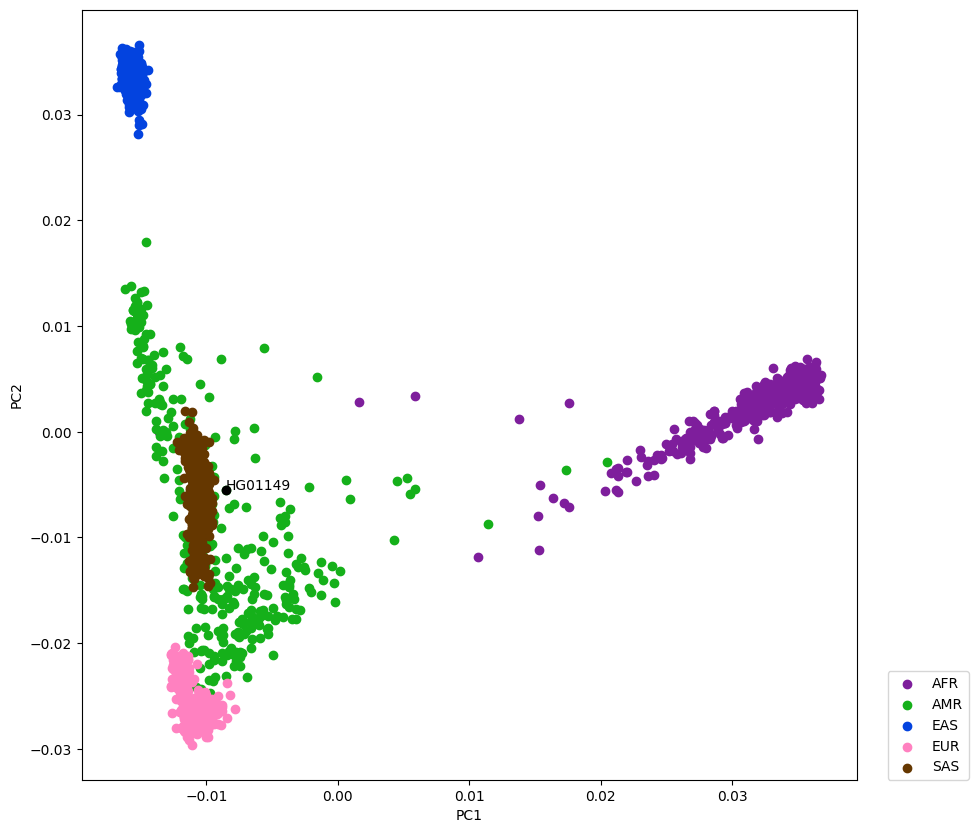

In [20]:
# Plot the top two PCs. Population labels = super_population
plot_pcs(pcs, 1, 2, pcs.super_population, [my_individual])

26


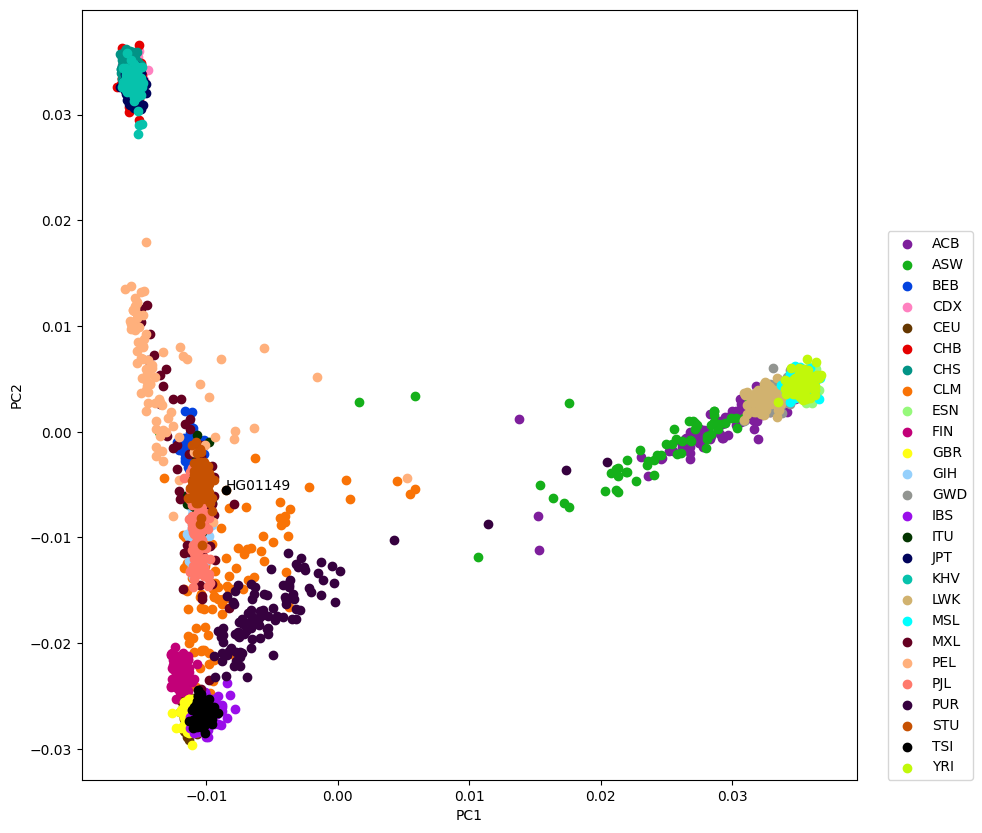

In [21]:
# Plot the top two PCs. Population labels = population
plot_pcs(pcs, 1, 2, pcs.population, [my_individual])

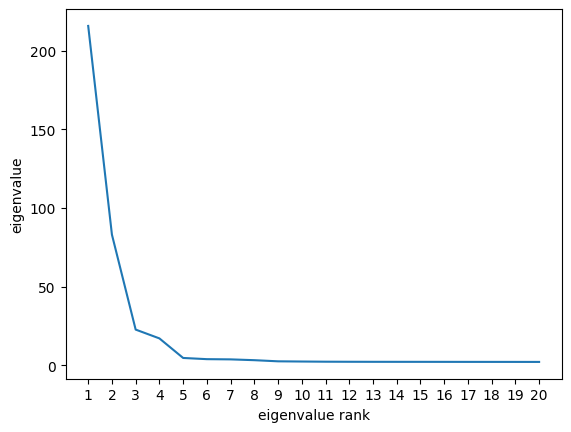

In [22]:
eigenvalues = np.loadtxt('1000G.eval')
plt.plot(np.arange(1, 21), eigenvalues[:20])
plt.xticks(np.arange(1, 21));
plt.xlabel('eigenvalue rank')
plt.ylabel('eigenvalue');

%Variance explained

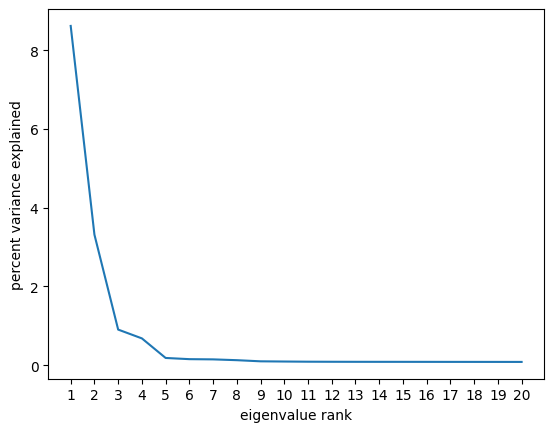

In [23]:
eigenvalues = np.loadtxt('1000G.eval')
plt.plot(np.arange(1, 21), 100 * eigenvalues[:20] / eigenvalues.sum())
plt.xticks(np.arange(1, 21));
plt.xlabel('eigenvalue rank')
plt.ylabel('percent variance explained');

## Exercise: explore your continental group

Write population list

In [24]:
np.savetxt('pop.list', individuals[individuals.super_population==my_continental_group].population.unique().astype(str), fmt='%s')

In [25]:
%%writefile 1000G.continent.smartpca.par
genotypename: 1000G.geno     # file with genotype information
snpname:      1000G.snp      # file with snp information
indivname:    1000G.ind      # file with individual information
poplistname:  pop.list # list of pops to include in the run.
evecoutname:  1000G.continent.evec     # output file of eigenvectors.
evaloutname:  1000G.continent.eval     # output file of all eigenvalues
snpweightoutname: 1000G.continent.Weightout.txt
phylipname:   1000G.continent.phyl     # file with Fst values across populations
numoutevec:   10               # number of PCs to output
numthreads:   1                # if running interactively, use 1 only
outliermode: 2
#outliermode should be 0, 1 or 2
#mode = 2  NO outlier removal
#mode = 1  when calculating mean and standard deviation of a PC to decide whether to remove a sample the
# sample itself is not used.   This may be important for datasets with very small sample sizes (say less than 30).
#mode = 0  (default) use all samples to compute PC mean and variance.

Writing 1000G.continent.smartpca.par


**Run smartpca (runtime ~30s)**

In [26]:
!../../bin/smartpca -p 1000G.continent.smartpca.par

parameter file: 1000G.continent.smartpca.par
### THE INPUT PARAMETERS
##PARAMETER NAME: VALUE
genotypename: 1000G.geno     
snpname: 1000G.snp      
indivname: 1000G.ind      
poplistname: pop.list 
evecoutname: 1000G.continent.evec     
evaloutname: 1000G.continent.eval     
snpweightoutname: 1000G.continent.Weightout.txt
phylipname: 1000G.continent.phyl     
numoutevec: 10               
numthreads: 1                
outliermode: 2
## smartpca version: 16000
norm used

number of samples used: 347 number of snps used: 19998
Using 1 thread, and partial sum lookup algorithm.
 snp          rs141842752 ignored . allelecnt:     0  missing:     0
 snp          rs144087919 ignored . allelecnt:     0  missing:     0
 snp           rs80151220 ignored . allelecnt:     0  missing:     0
 snp          rs182969387 ignored . allelecnt:     0  missing:     0
 snp          rs115254676 ignored . allelecnt:     0  missing:     0
 snp          rs138747494 ignored . allelecnt:     0  missing:     0
 snp 

In [27]:
# Display output
n_pcs = 10
pcs = pd.read_csv('1000G.continent.evec', skiprows=1, header=None, delim_whitespace=True,
                       names=['Sample']+['PC'+str(i+1) for i in range(n_pcs)]+['population'])
pcs = pcs.merge(population_info, on='population', how='left')
pcs = pcs[pcs.super_population==my_continental_group]
pcs.head()

,Sample,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,population,description,super_population
227,HG00551,0.0492,0.0260,0.0063,-0.0024,0.0068,0.0162,0.0015,0.0427,-0.0180,-0.0179,PUR,Puerto Ricans from Puerto Rico,AMR
228,HG00553,0.0416,-0.0411,0.0062,-0.0257,0.0223,0.0026,-0.0342,0.0354,-0.0769,-0.0034,PUR,Puerto Ricans from Puerto Rico,AMR
229,HG00554,0.0490,0.0211,-0.0055,-0.0029,0.0260,-0.0234,-0.0073,0.0302,-0.0051,0.0025,PUR,Puerto Ricans from Puerto Rico,AMR
265,HG00637,0.0579,-0.0025,-0.0086,-0.0127,0.0243,-0.0368,-0.0245,0.0059,-0.0417,0.0118,PUR,Puerto Ricans from Puerto Rico,AMR
266,HG00638,0.0539,-0.0175,-0.0001,-0.0223,0.0593,-0.0256,-0.0787,-0.0052,-0.0525,0.0636,PUR,Puerto Ricans from Puerto Rico,AMR


4


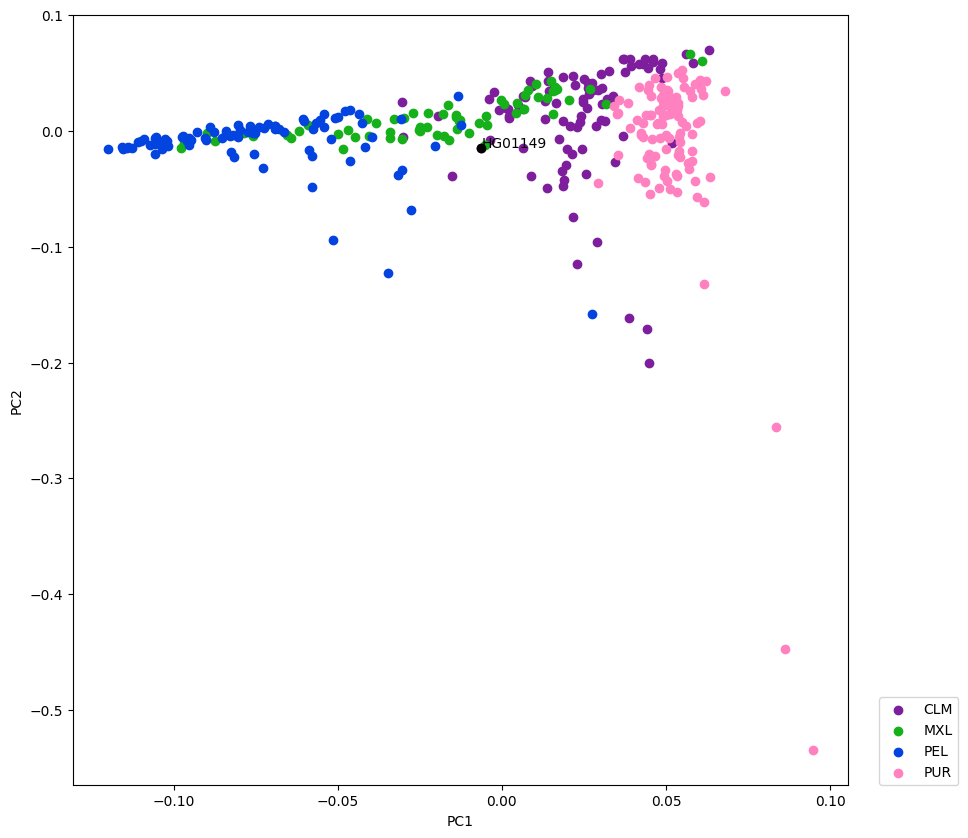

In [28]:
# plot PCA output
plot_pcs(pcs, 1, 2, pcs.population, [my_individual])

### Stop! Check your understanding
1. Find your individual in our individuals dataframe; what is their sex, population, and superpopulation?


In [29]:
! cat '1000G.continent.phyl'

     4
       CLM 0.000 0.010 0.041 0.006
       MXL 0.010 0.000 0.018 0.020
       PEL 0.041 0.018 0.000 0.060
       PUR 0.006 0.020 0.060 0.000


The smartpca program also outputs useful statistics after each run. One of these files, [name].phyl, has information about Fst values between all populations within your superpopulation.<br>
<br>
&emsp;&emsp;<ins>Fst</ins>: a measure of genetic differentiation between two populations, based on within-population structure.
2. Find the value of Fst between your population and every other one in the superpopulation.

# Admixture analysis

Alexander, David H., John Novembre, and Kenneth Lange. "Fast model-based estimation of ancestry in unrelated individuals." Genome research 19.9 (2009): 1655-1664.

https://genome.cshlp.org/content/19/9/1655.full

Software documentation: http://dalexander.github.io/admixture/admixture-manual.pdf
Usage:

```!../../bin/admixture --cv 1000G.bed K```

where K = number of clusters

Data format: Plink https://www.cog-genomics.org/plink/1.9/formats#bed

**Let's run admixture with K=2 clusters** (runtime: ~4m)

In [ ]:
!../../bin/admixture --cv 1000G.bed 2

Output of ADMIXTURE (K=2)

Each line in the output of ADMIXTURE contains the probability of an individual belonging to each cluster - not be to confused with ancestry proportion.

In [39]:
admix = pd.read_csv('1000G.2.Q', ' ', header=None).values[order]
admix

<ipython-input-39-ed03a73b2272>:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  admix2 = pd.read_csv('1000G.2.Q', ' ', header=None)


,0,1
0,0.997158,0.002842
1,0.999990,0.000010
2,0.998013,0.001987
3,0.999990,0.000010
4,0.995615,0.004385


<ipython-input-4-cdf958995c74>:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  subplot.set_xticklabels(xtick_labels)
<ipython-input-4-cdf958995c74>:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  subplot.set_yticklabels(ytick_labels)


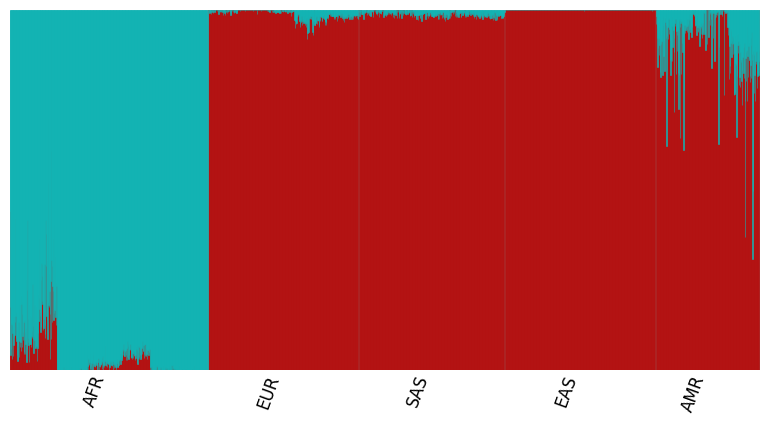

In [32]:
plot_admixture(admix, individuals.super_population.cat.codes, individuals.super_population.cat.categories);

Admixture plot with subcontinental ancestry where each color represents one cluster


<ipython-input-4-cdf958995c74>:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  subplot.set_xticklabels(xtick_labels)
<ipython-input-4-cdf958995c74>:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  subplot.set_yticklabels(ytick_labels)


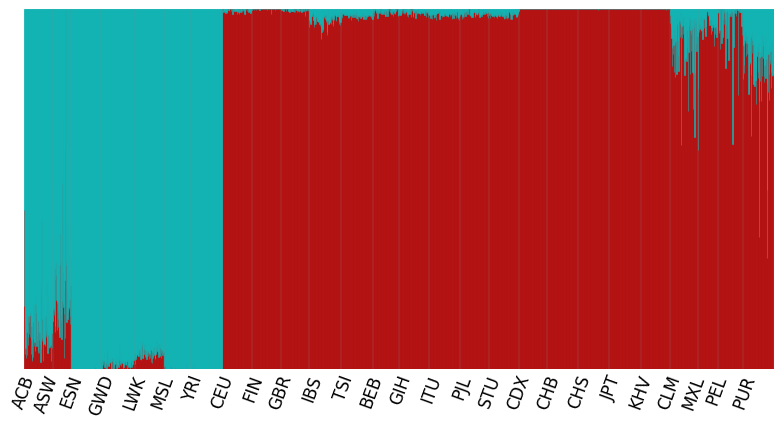

In [33]:
plot_admixture(admix, individuals.population.cat.codes, individuals.population.cat.categories);

Admixture output for the current individual


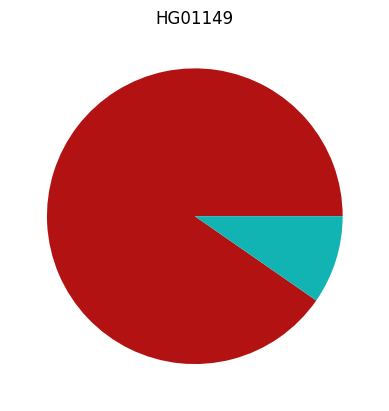

In [34]:
plot_admix_individual(admix, my_individual)

For K=3,4,5,6 results have been precomputed, we can just load them. <br><br>Output of ADMIXTURE (K=3)


<ipython-input-41-b205410402b0>:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  admix = pd.read_csv('1000G.3.Q', ' ', header=None).values[order]
<ipython-input-4-cdf958995c74>:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  subplot.set_xticklabels(xtick_labels)
<ipython-input-4-cdf958995c74>:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  subplot.set_yticklabels(ytick_labels)


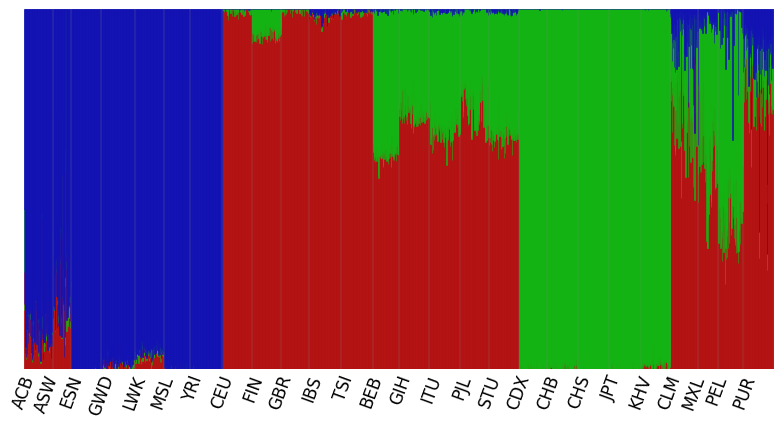

In [41]:
admix = pd.read_csv('1000G.3.Q', ' ', header=None).values[order]
plot_admixture(admix, individuals.population.cat.codes, individuals.population.cat.categories);

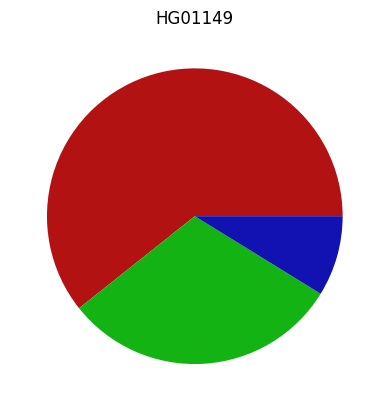

In [42]:
# Admixture output for the current individual (K=3)
plot_admix_individual(admix, my_individual)

Output of ADMIXTURE (K=4)

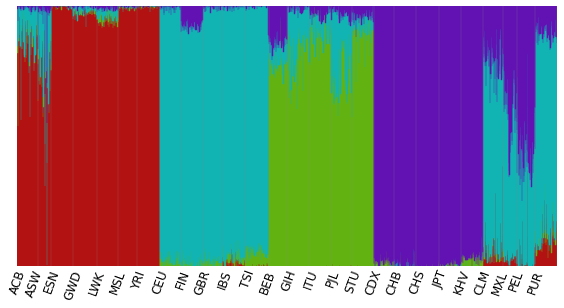

In [ ]:
admix = pd.read_csv('1000G.4.Q', ' ', header=None).values[order]
plot_admixture(admix, individuals.population.cat.codes, individuals.population.cat.categories);

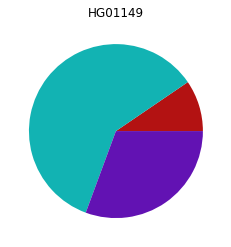

In [ ]:
# Admixture output for the current individual (K=4)
plot_admix_individual(admix, my_individual)

Output of ADMIXTURE (K=5)


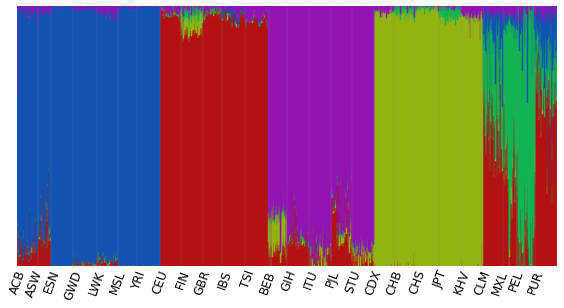

In [ ]:
admix = pd.read_csv('1000G.5.Q', ' ', header=None).values[order]
plot_admixture(admix, individuals.population.cat.codes, individuals.population.cat.categories);

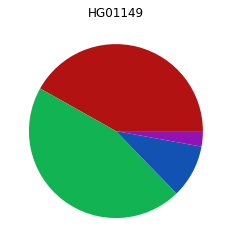

In [ ]:
plot_admix_individual(admix, my_individual)

Output of ADMIXTURE (K=6)


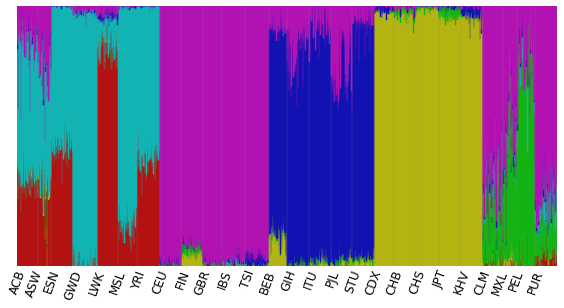

In [ ]:
admix = pd.read_csv('1000G.6.Q', ' ', header=None).values[order]
plot_admixture(admix, individuals.population.cat.codes, individuals.population.cat.categories);

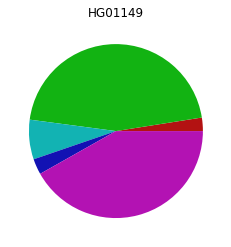

In [ ]:
plot_admix_individual(admix, my_individual)

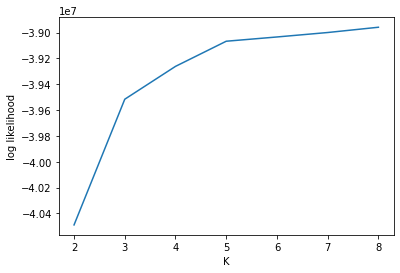

In [ ]:
# Likelihood of data as a function of K, the number of clusters
K = np.arange(2, 9)
log_likelihood = [-40488756, -39516004, -39261878, -39067307, -39034320, -38999856, -38959044]
plt.plot(K, log_likelihood)
plt.xticks(K)
plt.xlabel('K')
plt.ylabel('log likelihood');